# USING SMOTE AND TRANSFORMATION TECHNIQUES ON THE LOAN DATA.

In [1]:
import numpy as np
import pandas as pd
from pandas import Series as ser
from pandas import DataFrame as df
import seaborn as sns
import scipy
from scipy import stats
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import PowerTransformer , StandardScaler , LabelEncoder
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import statsmodels.api as sm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import  classification_report , confusion_matrix , roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV

### IMPORTING DATA AFTER DATA CLEANING AND WRANGLING IN SCRIPT BEFORE.

In [2]:
data = pd.read_csv("Cleaned_Data.csv")
data.head(2)

,Unnamed: 0,Asst_Reg,GGGrade,Experience,Validation,Yearly Income,Home Status,Unpaid 2 years,Already Defaulted,Debt to Income,...,Usage Rate,Inquiries,Present Balance,Gross Collection,File Status,Total Unpaid CL,Duration,Unpaid Amount,Due Fee,Loan/No Loan
0,0,421802,II,experienced,Vfied,633600.0,Mortgage,no risk,0,12.5496,...,88.924,3,607161.90,0.0,fully paid,58598.0,3 years,31216.05,0.0,0.0
1,1,3964312,IV,not much,Source Verified,85483.2,Rental,no risk,0,9.0048,...,102.856,0,269234.06,0.0,whole,18924.0,5 years,11660.49,0.0,0.0


In [3]:
data.drop("Unnamed: 0" , axis=1 , inplace= True)

In [4]:
data.shape

(125000, 22)

In [5]:
newtrain = data.loc[0:87499] 


In [6]:
newtrain["Loan/No Loan"].value_counts()

0.0    70988
1.0    16512
Name: Loan/No Loan, dtype: int64

In [7]:
newtrain.isna().any()

Asst_Reg               False
GGGrade                False
Experience             False
Validation             False
Yearly Income          False
Home Status            False
Unpaid 2 years         False
Already Defaulted      False
Debt to Income         False
Lend Amount            False
Deprecatory Records    False
Interest Charged       False
Usage Rate             False
Inquiries              False
Present Balance        False
Gross Collection       False
File Status            False
Total Unpaid CL        False
Duration               False
Unpaid Amount          False
Due Fee                False
Loan/No Loan           False
dtype: bool

In [8]:
newtrain= pd.get_dummies(newtrain , drop_first=True)

In [9]:
newtrain.head(2)

,Asst_Reg,Yearly Income,Already Defaulted,Debt to Income,Lend Amount,Interest Charged,Usage Rate,Inquiries,Present Balance,Gross Collection,...,Validation_Vfied,Home Status_Owned,Home Status_Rental,Home Status_others,Unpaid 2 years_Risk,Unpaid 2 years_no risk,Deprecatory Records_okayish,Deprecatory Records_risky,File Status_whole,Duration_5 years
0,421802,633600.0,0,12.5496,42023.25,15.39,88.924,3,607161.90,0.0,...,1,0,0,0,0,1,0,0,0,0
1,3964312,85483.2,0,9.0048,38133.00,9.94,102.856,0,269234.06,0.0,...,0,0,1,0,0,1,0,0,1,1


In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
X = newtrain.drop('Loan/No Loan', axis=1)  
y = newtrain['Loan/No Loan']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, stratify=y, random_state=2)

In [12]:
sm = SMOTE(random_state=1)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
print(len(y_SMOTE))
print(y_SMOTE.sum())

95124
47562.0


In [13]:
y_SMOTE.value_counts()

0.0    47562
1.0    47562
Name: Loan/No Loan, dtype: int64

In [14]:
rf= RandomForestClassifier()
model = rf.fit(X_SMOTE, y_SMOTE)
pred = rf.predict(X_test)


In [15]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89     23426
         1.0       0.50      0.41      0.45      5449

    accuracy                           0.81     28875
   macro avg       0.69      0.66      0.67     28875
weighted avg       0.80      0.81      0.80     28875



In [16]:
print(confusion_matrix(y_test , pred))

[[21228  2198]
 [ 3231  2218]]


In [17]:
accuracy_score(y_test , pred)

0.811982683982684

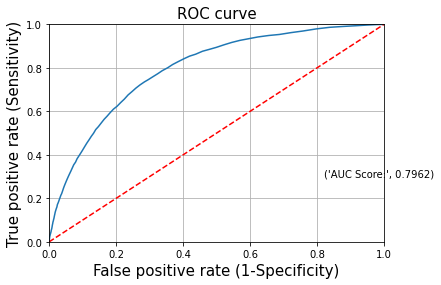

In [18]:
def plot_roc(model):
    y_pred_prob = rf.predict_proba(X_test)[:,1]
    
    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    # pass the actual target values and predicted probabilities to the function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.82, y = 0.3, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)
    
plot_roc(rf)    

### SMOTE WITH FEATURE SELECTIONS.

In [19]:
x=X_SMOTE.drop(["Yearly Income","Already Defaulted","Interest Charged","Gross Collection","Total Unpaid CL",
            "Experience_not much","Validation_Vfied","Home Status_Owned","Home Status_others",
            "Deprecatory Records_okayish","Deprecatory Records_risky"], axis=1)

In [20]:
X_SMOTE.shape , y_SMOTE.shape

((95124, 31), (95124,))

In [21]:
x.shape

(95124, 20)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x,y_SMOTE, test_size=0.3, random_state=2)

**RANDOM FOREST**

In [23]:
rf1= RandomForestClassifier()
model = rf1.fit(X_train, y_train)
pred = rf1.predict(X_test)


In [24]:
print(classification_report(y_test , pred))
print(confusion_matrix(y_test , pred))
print(accuracy_score(y_test , pred))

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86     14321
         1.0       0.88      0.83      0.85     14217

    accuracy                           0.86     28538
   macro avg       0.86      0.86      0.86     28538
weighted avg       0.86      0.86      0.86     28538

[[12639  1682]
 [ 2401 11816]]
0.8569276052981989


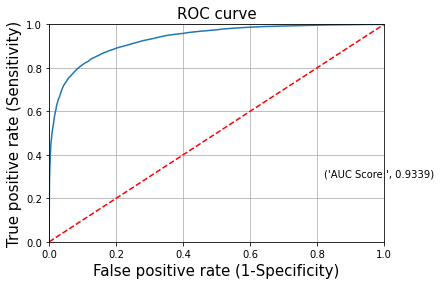

In [25]:
def plot_roc(model):
    y_pred_prob = rf1.predict_proba(X_test)[:,1]
    
    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    # pass the actual target values and predicted probabilities to the function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.82, y = 0.3, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)
    
plot_roc(rf1)    

**GRADIENT BOOSTING**

In [26]:
gbm=GradientBoostingClassifier()
model = gbm.fit(X_train, y_train)
preds = gbm.predict(X_test)

print(confusion_matrix(y_test , preds))
print(classification_report(y_test , preds))
print(accuracy_score(y_test , preds))

[[12138  2183]
 [ 2622 11595]]
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83     14321
         1.0       0.84      0.82      0.83     14217

    accuracy                           0.83     28538
   macro avg       0.83      0.83      0.83     28538
weighted avg       0.83      0.83      0.83     28538

0.8316280047655757


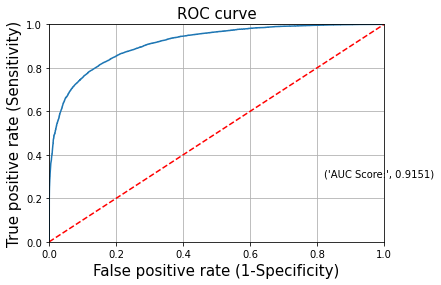

In [27]:
def plot_roc(model):
    y_pred_prob = gbm.predict_proba(X_test)[:,1]
    
    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    # pass the actual target values and predicted probabilities to the function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.82, y = 0.3, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)
    
plot_roc(gbm)    

### APPLYING POWER TRANSFORMER TECHNIQUES TO RESOLVE DATA SKEWNESS.

In [28]:
t = newtrain.drop('Loan/No Loan', axis=1)

In [29]:
power = PowerTransformer()
t = power.fit_transform(t)

In [30]:
X = t
y = newtrain['Loan/No Loan']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, stratify=y, random_state=2)

In [31]:
sm = SMOTE(random_state=1)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
print(len(y_SMOTE))
print(y_SMOTE.sum())

95124
47562.0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE,y_SMOTE, test_size=0.3, random_state=2)

**RANDOM FOREST WITH POWER TRANSFORMER AND SMOTE**

In [33]:
rf2= RandomForestClassifier()
model = rf2.fit(X_train, y_train)
pred = rf2.predict(X_test)
print(classification_report(y_test , pred))
print(confusion_matrix(y_test , pred))
print(accuracy_score(y_test , pred))

              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87     14321
         1.0       0.86      0.90      0.88     14217

    accuracy                           0.88     28538
   macro avg       0.88      0.88      0.88     28538
weighted avg       0.88      0.88      0.88     28538

[[12183  2138]
 [ 1413 12804]]
0.8755694162169738


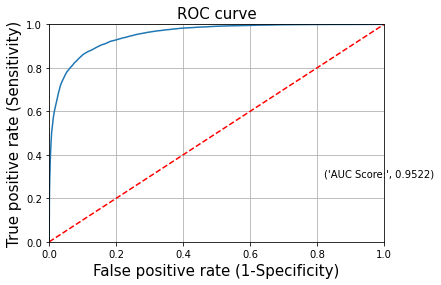

In [34]:
def plot_roc(model):
    y_pred_prob = rf2.predict_proba(X_test)[:,1]
    
    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    # pass the actual target values and predicted probabilities to the function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.82, y = 0.3, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)
    
plot_roc(rf2)    

**GRADIENT BOOSTING WITH POWER TRANSFORMER AND SMOTE**

In [35]:
gbm1=GradientBoostingClassifier()
model = gbm1.fit(X_train, y_train)
preds = gbm1.predict(X_test)

print(confusion_matrix(y_test , preds))
print(classification_report(y_test , preds))
print(accuracy_score(y_test , preds))

[[11409  2912]
 [ 2052 12165]]
              precision    recall  f1-score   support

         0.0       0.85      0.80      0.82     14321
         1.0       0.81      0.86      0.83     14217

    accuracy                           0.83     28538
   macro avg       0.83      0.83      0.83     28538
weighted avg       0.83      0.83      0.83     28538

0.8260564860887238


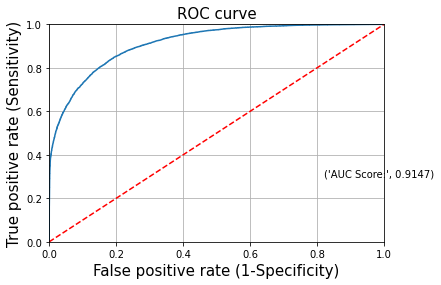

In [38]:
def plot_roc(model):
    y_pred_prob = gbm1.predict_proba(X_test)[:,1]
    
    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    # pass the actual target values and predicted probabilities to the function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.82, y = 0.3, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)
    
plot_roc(gbm1)    

### APPLYING FEATURE SELECTION, POWER TRANSFORMER AND SMOTE PROCESS

In [39]:
newtrain.columns

Index(['Asst_Reg', 'Yearly Income', 'Already Defaulted', 'Debt to Income',
       'Lend Amount', 'Interest Charged', 'Usage Rate', 'Inquiries',
       'Present Balance', 'Gross Collection', 'Total Unpaid CL',
       'Unpaid Amount', 'Due Fee', 'Loan/No Loan', 'GGGrade_II', 'GGGrade_III',
       'GGGrade_IV', 'GGGrade_V', 'GGGrade_VI', 'GGGrade_VII',
       'Experience_not much', 'Validation_Source Verified', 'Validation_Vfied',
       'Home Status_Owned', 'Home Status_Rental', 'Home Status_others',
       'Unpaid 2 years_Risk', 'Unpaid 2 years_no risk',
       'Deprecatory Records_okayish', 'Deprecatory Records_risky',
       'File Status_whole', 'Duration_5 years'],
      dtype='object')

In [40]:
t=df(t, columns=['Asst_Reg', 'Yearly Income', 'Already Defaulted', 'Debt to Income',
       'Lend Amount', 'Interest Charged', 'Usage Rate', 'Inquiries',
       'Present Balance', 'Gross Collection', 'Total Unpaid CL',
       'Unpaid Amount', 'Due Fee',  'GGGrade_II', 'GGGrade_III',
       'GGGrade_IV', 'GGGrade_V', 'GGGrade_VI', 'GGGrade_VII',
       'Experience_not much', 'Validation_Source Verified', 'Validation_Vfied',
       'Home Status_Owned', 'Home Status_Rental', 'Home Status_others',
       'Unpaid 2 years_Risk', 'Unpaid 2 years_no risk',
       'Deprecatory Records_okayish', 'Deprecatory Records_risky',
       'File Status_whole', 'Duration_5 years'])

In [41]:
x=t.drop(["Yearly Income","Already Defaulted","Interest Charged","Gross Collection","Total Unpaid CL",
            "Experience_not much","Validation_Vfied","Home Status_Owned","Home Status_others",
            "Deprecatory Records_okayish","Deprecatory Records_risky"], axis=1)

In [42]:
X = x
y = newtrain['Loan/No Loan']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, stratify=y, random_state=2)

In [43]:
sm = SMOTE(random_state=1)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
print(len(y_SMOTE))
print(y_SMOTE.sum())

95124
47562.0


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE,y_SMOTE, test_size=0.3, random_state=2)

**RANDOM FOREST WITH FEATURE SELECTION, POWER TRANSFORMER AND SMOTE**

In [45]:
rf3= RandomForestClassifier()
model = rf3.fit(X_train, y_train)
pred = rf3.predict(X_test)
print(classification_report(y_test , pred))
print(confusion_matrix(y_test , pred))
print(accuracy_score(y_test , pred))

              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85     14321
         1.0       0.83      0.89      0.86     14217

    accuracy                           0.86     28538
   macro avg       0.86      0.86      0.86     28538
weighted avg       0.86      0.86      0.86     28538

[[11784  2537]
 [ 1573 12644]]
0.8559814983530731


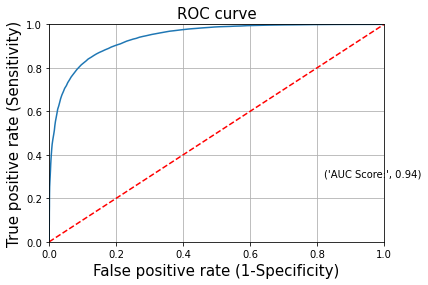

In [46]:
def plot_roc(model):
    y_pred_prob = rf3.predict_proba(X_test)[:,1]
    
    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    # pass the actual target values and predicted probabilities to the function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.82, y = 0.3, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)
    
plot_roc(rf3)    